## Import libraries and check package versions

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pickle
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

In [9]:
import streamlit

In [10]:
print("Pandas: ",pd.__version__)
print("Numpy: ",np.__version__)
!python --version
print("sklearn: ",sklearn.__version__)
print("streamlit: ",streamlit.__version__)

Pandas:  2.2.0
Numpy:  1.26.3
Python 3.11.7


sklearn:  1.4.0
streamlit:  1.31.0


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.4.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/axu/miniconda3/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: evidently, imbalanced-learn


In [4]:
!which python

/Users/axu/miniconda3/bin/python


In [5]:
!which conda

/Users/axu/miniconda3/bin/conda


In [6]:
!conda --version

conda 24.1.0


In [7]:
#!pip3 freeze > requirements.txt
#!pip list --format=freeze > requirements.txt

## EDA

In [8]:
# upload data to the colab folder, and then load the data below
df = pd.read_csv("./CHLA_Prediction/CHLA_clean_data_until_2023.csv")

# check data
df.head()

,MRN,APPT_STATUS,APPT_DATE,BOOK_DATE,ZIPCODE,CLINIC,SCHEDULE_ID,APPT_ID,LEAD_TIME,IS_REPEAT,...,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_NOSHOW,DAY_OF_WEEK,WEEK_OF_MONTH,NUM_OF_MONTH,HOUR_OF_DAY,IS_NOSHOW,AGE,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE
0,1946298,CONFIRMED,12/26/23 10:30,6/6/23 10:32,91387,VALENCIA CARE CENTER,22576917,77137126,202,Y,...,5,0,1,4,12,10,N,14,Non-Hispanic,European
1,4464320,RESCHEDULED,12/26/23 10:00,12/27/22 10:19,91354,VALENCIA CARE CENTER,21812159,74489619,363,Y,...,2,0,1,4,12,10,N,3,Others,Other
2,4464320,CONFIRMED,12/26/23 10:00,12/27/22 10:19,91354,VALENCIA CARE CENTER,22496669,76863542,363,Y,...,2,0,1,4,12,10,N,3,Others,Other
3,4146637,CONFIRMED,12/21/23 10:30,1/23/23 10:59,91350,VALENCIA CARE CENTER,22466003,76767204,331,Y,...,4,0,3,3,12,10,N,12,Non-Hispanic,European
4,4460795,CONFIRMED,12/18/23 9:00,1/9/23 10:59,91402,VALENCIA CARE CENTER,21862889,74656637,342,Y,...,3,0,0,3,12,9,N,13,Others,Other


In [9]:
# explore the data
print("Shape: ",df.shape,"\n", "-"*50)
print("DF Info:", df.info(), "\n", "-"*50)

# identify target (y)
print("Target value: IS_NOSHOW",df["IS_NOSHOW"].unique())

Shape:  (21060, 25) 
 --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   MRN                                       21060 non-null  int64 
 1   APPT_STATUS                               21060 non-null  object
 2   APPT_DATE                                 21060 non-null  object
 3   BOOK_DATE                                 21060 non-null  object
 4   ZIPCODE                                   21060 non-null  object
 5   CLINIC                                    21060 non-null  object
 6   SCHEDULE_ID                               21060 non-null  int64 
 7   APPT_ID                                   21060 non-null  int64 
 8   LEAD_TIME                                 21060 non-null  int64 
 9   IS_REPEAT                                 2

In [10]:
# copy the original df to edit a new one
df_model = df.copy()

# drop features that don't make business sense for our model
df_model = df_model.drop(['MRN', 'APPT_STATUS', 'SCHEDULE_ID', 'APPT_ID', 'APPT_NUM'], axis = 1)

In [11]:
# data quality report
missing_values = df_model.isnull().sum()
percent_missing = df_model.isnull().mean()*100
data_types = df_model.dtypes
unique_values = df_model.nunique()

quality_report = pd.DataFrame(
    {"Missing Values": missing_values,
     'Percent Missing': percent_missing,
     'Data Type': data_types,
     'Number of Unique Values': unique_values})

quality_report

,Missing Values,Percent Missing,Data Type,Number of Unique Values
APPT_DATE,0,0.0,object,11296
BOOK_DATE,0,0.0,object,15770
ZIPCODE,0,0.0,object,598
CLINIC,0,0.0,object,6
LEAD_TIME,0,0.0,int64,323
IS_REPEAT,0,0.0,object,2
APPT_TYPE_STANDARDIZE,0,0.0,object,3
TOTAL_NUMBER_OF_CANCELLATIONS,0,0.0,int64,9
TOTAL_NUMBER_OF_RESCHEDULED,0,0.0,int64,16
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT,0,0.0,int64,3


In [12]:
# describe non-numerical data types
df_model.select_dtypes(include='object').describe(include='all')

,APPT_DATE,BOOK_DATE,ZIPCODE,CLINIC,IS_REPEAT,APPT_TYPE_STANDARDIZE,IS_NOSHOW,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE
count,21060,21060,21060,21060,21060,21060,21060,21060,21060
unique,11296,15770,598,6,2,3,2,3,7
top,9/24/18 11:00,8/29/18 15:18,91350,ARCADIA CARE CENTER,Y,Follow-up,N,Others,Other
freq,11,8,550,7381,13951,12734,20027,11359,11111


## Below is where I might not do it right!

In [13]:
# assign the column names
col_names = df_model.columns

In [14]:
# encoding the non-numerical values with label encoder
category_col =['APPT_DATE', 'BOOK_DATE', 'ZIPCODE', 'CLINIC', 'IS_REPEAT', 'APPT_TYPE_STANDARDIZE', 'IS_NOSHOW', 'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']

lbl_data = df_model.copy()

df_input = df_model[category_col].copy()

enc = preprocessing.LabelEncoder()
encoder_dict = dict()

for cat in category_col:
    df_input[cat] = df_input[cat].str.strip()
    enc = enc.fit(list(df_input[cat]))                # removed "+ 'Unknown'" to avoid adding a 3rd category to our target of 0 and 1
    encoder_dict[cat] = [cat for cat in enc.classes_]
    lbl_data[cat] = enc.transform(df_input[cat])

In [15]:
lbl_data.head()

,APPT_DATE,BOOK_DATE,ZIPCODE,CLINIC,LEAD_TIME,IS_REPEAT,APPT_TYPE_STANDARDIZE,TOTAL_NUMBER_OF_CANCELLATIONS,TOTAL_NUMBER_OF_RESCHEDULED,TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_NOSHOW,DAY_OF_WEEK,WEEK_OF_MONTH,NUM_OF_MONTH,HOUR_OF_DAY,IS_NOSHOW,AGE,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE
0,3615,11999,297,5,202,1,0,1,2,0,5,0,1,4,12,10,0,14,1,2
1,3614,5034,280,5,363,1,0,0,1,0,2,0,1,4,12,10,0,3,2,5
2,3614,5034,280,5,363,1,0,0,1,0,2,0,1,4,12,10,0,3,2,5
3,3567,759,276,5,331,1,0,2,8,0,4,0,3,3,12,10,0,12,1,2
4,3396,1522,300,5,342,1,0,1,1,0,3,0,0,3,12,9,0,13,2,5


In [16]:
# check the encoded dict
print(encoder_dict)

{'APPT_DATE': ['1/10/19 10:50', '1/10/19 11:25', '1/10/19 13:00', '1/10/19 13:35', '1/10/19 14:10', '1/10/19 14:40', '1/10/19 14:45', '1/10/19 15:20', '1/10/19 8:30', '1/10/19 9:40', '1/10/20 13:00', '1/10/20 13:30', '1/10/20 14:05', '1/10/20 14:40', '1/10/20 15:15', '1/10/20 15:50', '1/10/20 16:25', '1/10/20 8:00', '1/10/20 8:30', '1/10/20 9:00', '1/10/22 10:00', '1/10/22 10:30', '1/10/22 11:00', '1/10/22 11:30', '1/10/22 12:00', '1/10/22 12:30', '1/10/22 13:30', '1/10/22 14:00', '1/10/22 14:30', '1/10/22 15:00', '1/10/22 15:30', '1/10/22 8:00', '1/10/22 9:00', '1/10/22 9:30', '1/10/23 10:00', '1/10/23 10:30', '1/10/23 11:00', '1/10/23 11:30', '1/10/23 12:00', '1/10/23 12:30', '1/10/23 13:30', '1/10/23 14:00', '1/10/23 14:30', '1/10/23 15:00', '1/10/23 15:30', '1/10/23 8:30', '1/10/23 9:00', '1/10/23 9:30', '1/11/22 10:00', '1/11/22 10:30', '1/11/22 11:00', '1/11/22 11:30', '1/11/22 12:00', '1/11/22 12:30', '1/11/22 14:30', '1/11/22 15:00', '1/11/22 15:30', '1/11/22 8:30', '1/11/22 9:

In [17]:
# quality report on our encoded data
missing_values = lbl_data.isnull().sum()
percent_missing = lbl_data.isnull().mean()*100
data_types = lbl_data.dtypes
unique_values = lbl_data.nunique()

quality_report = pd.DataFrame(
    {"Missing Values": missing_values,
     'Percent Missing': percent_missing,
     'Data Type': data_types,
     'Number of Unique Values': unique_values})

quality_report

,Missing Values,Percent Missing,Data Type,Number of Unique Values
APPT_DATE,0,0.0,int64,11296
BOOK_DATE,0,0.0,int64,15770
ZIPCODE,0,0.0,int64,598
CLINIC,0,0.0,int64,6
LEAD_TIME,0,0.0,int64,323
IS_REPEAT,0,0.0,int64,2
APPT_TYPE_STANDARDIZE,0,0.0,int64,3
TOTAL_NUMBER_OF_CANCELLATIONS,0,0.0,int64,9
TOTAL_NUMBER_OF_RESCHEDULED,0,0.0,int64,16
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT,0,0.0,int64,3


In [18]:
# encountered an issue earlier where the target was encoded as 0 and 2 instead of 0 and 1, but I resolved it (2 code sections above)
  # the target is now encoded as 0 and 1
print(df_model['IS_NOSHOW'].unique())

lbl_data['IS_NOSHOW'].describe()

['N' 'Y']


count    21060.000000
mean         0.049050
std          0.215978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IS_NOSHOW, dtype: float64

In [19]:
# save label encoder
encoder_pickle_out = open("./CHLA_Prediction/encoder_V2.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

Text(0.5, 1.0, 'Show vs No-Show')

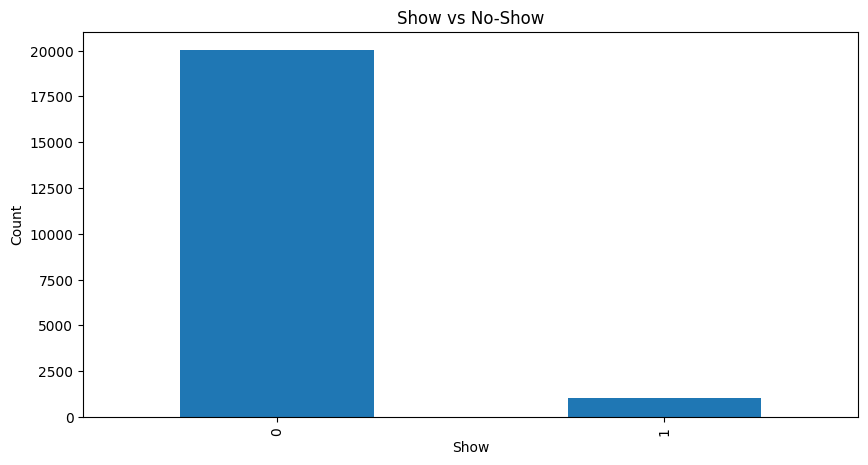

In [20]:
# plot the target
plt.figure(figsize=(10,5))
ax = lbl_data.IS_NOSHOW.value_counts().plot(kind = 'bar')
plt.xlabel("Show")
plt.ylabel("Count")
plt.title("Show vs No-Show")

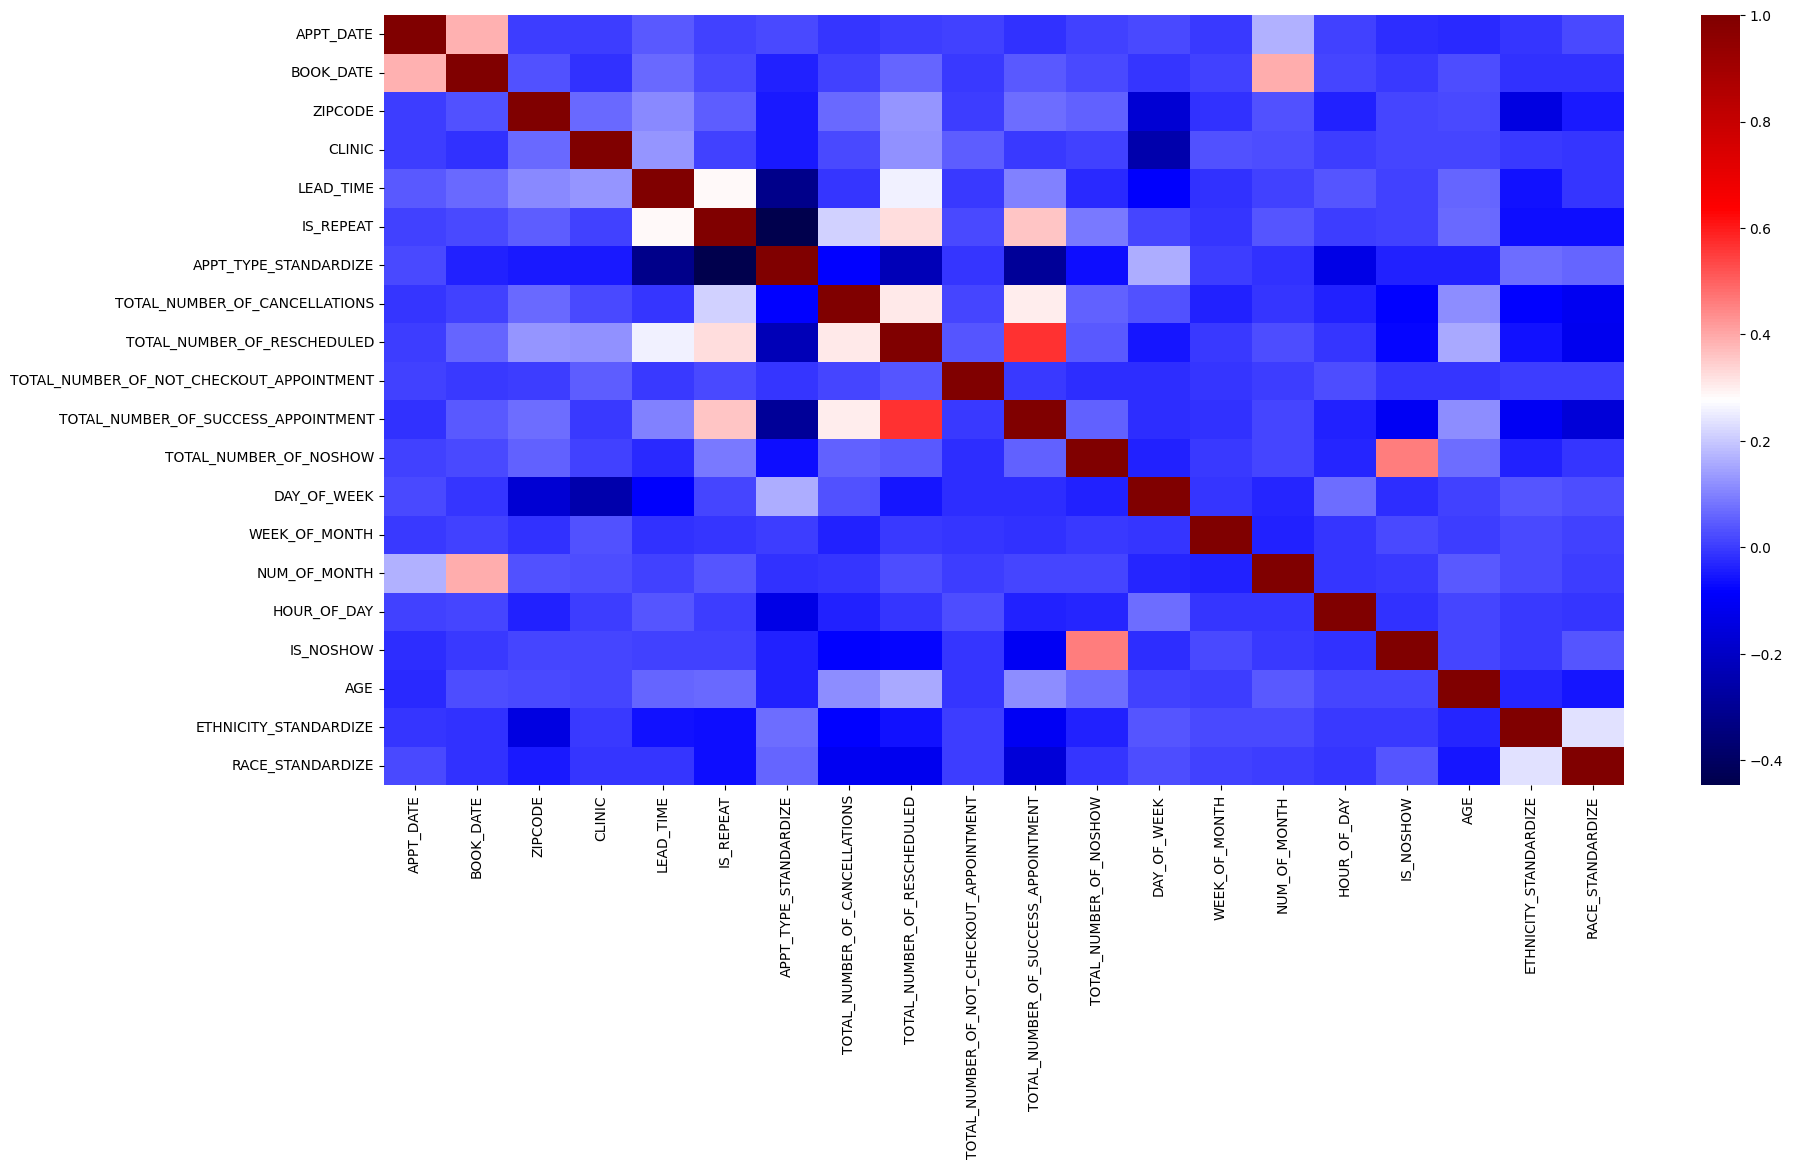

In [21]:
# correlation matrix with heatmaps
plt.figure(figsize=(20,10))
sns.heatmap(data=lbl_data.corr(), cmap="seismic")
plt.show()

## SMOTE

In [22]:
## Undersampling
df_class_N = lbl_data[lbl_data['IS_NOSHOW'] == 0]
df_class_Y = lbl_data[lbl_data['IS_NOSHOW'] == 1]

# Resample the majority class to have the same number of instances as the minority class
df_class_N_resampled = resample(df_class_N, replace=False, n_samples=2000, random_state=42)

# Concatenate the resampled majority class with the minority class
df_balanced = pd.concat([df_class_N_resampled, df_class_Y])

In [23]:
## Undersampling
sm = SMOTE(random_state=42)

df_sm_N = lbl_data.drop("IS_NOSHOW", axis = 1)
df_sm_Y = lbl_data['IS_NOSHOW']

# Resample the majority class to have the same number of instances as the minority class
df_sm_N_resampled, df_sm_Y_resampled = sm.fit_resample(df_sm_N, df_sm_Y)

df_sm_N_resampled = pd.DataFrame(df_sm_N_resampled, columns=df_sm_N.columns)

df_sm_resampled = pd.concat([df_sm_N_resampled, df_sm_Y_resampled.reset_index(drop=True)], axis=1)
df_sm_resampled

,APPT_DATE,BOOK_DATE,ZIPCODE,CLINIC,LEAD_TIME,IS_REPEAT,APPT_TYPE_STANDARDIZE,TOTAL_NUMBER_OF_CANCELLATIONS,TOTAL_NUMBER_OF_RESCHEDULED,TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_NOSHOW,DAY_OF_WEEK,WEEK_OF_MONTH,NUM_OF_MONTH,HOUR_OF_DAY,AGE,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE,IS_NOSHOW
0,3615,11999,297,5,202,1,0,1,2,0,5,0,1,4,12,10,14,1,2,0
1,3614,5034,280,5,363,1,0,0,1,0,2,0,1,4,12,10,3,2,5,0
2,3614,5034,280,5,363,1,0,0,1,0,2,0,1,4,12,10,3,2,5,0
3,3567,759,276,5,331,1,0,2,8,0,4,0,3,3,12,10,12,1,2,0
4,3396,1522,300,5,342,1,0,1,1,0,3,0,0,3,12,9,13,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40049,8863,11661,237,3,15,1,0,2,2,0,1,1,1,2,7,10,10,2,5,1
40050,1754,10756,551,5,165,1,0,0,1,0,0,1,0,4,10,11,10,0,3,1
40051,623,220,169,1,10,0,0,0,0,0,0,1,1,3,1,9,20,2,5,1
40052,8345,9411,161,0,39,1,1,0,1,0,0,1,2,2,6,11,3,2,5,1


In [24]:
df_sm_resampled.IS_NOSHOW.value_counts()

IS_NOSHOW
0    20027
1    20027
Name: count, dtype: int64

Text(0.5, 1.0, 'Show vs No-Show')

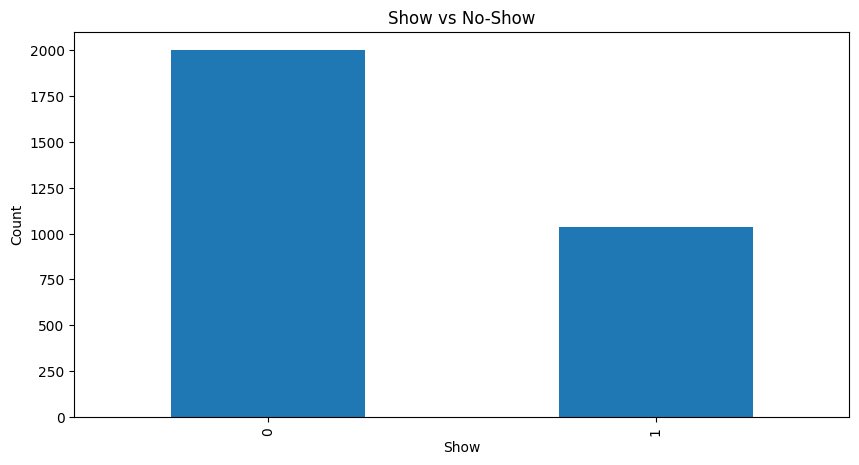

In [25]:
plt.figure(figsize=(10,5))
ax = df_balanced.IS_NOSHOW.value_counts().plot(kind = 'bar')
plt.xlabel("Show")
plt.ylabel("Count")
plt.title("Show vs No-Show")

## Model Building

In [26]:
# label the data
Y = df_balanced['IS_NOSHOW']
X = df_balanced.drop('IS_NOSHOW', axis = 1)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100, stratify= Y)

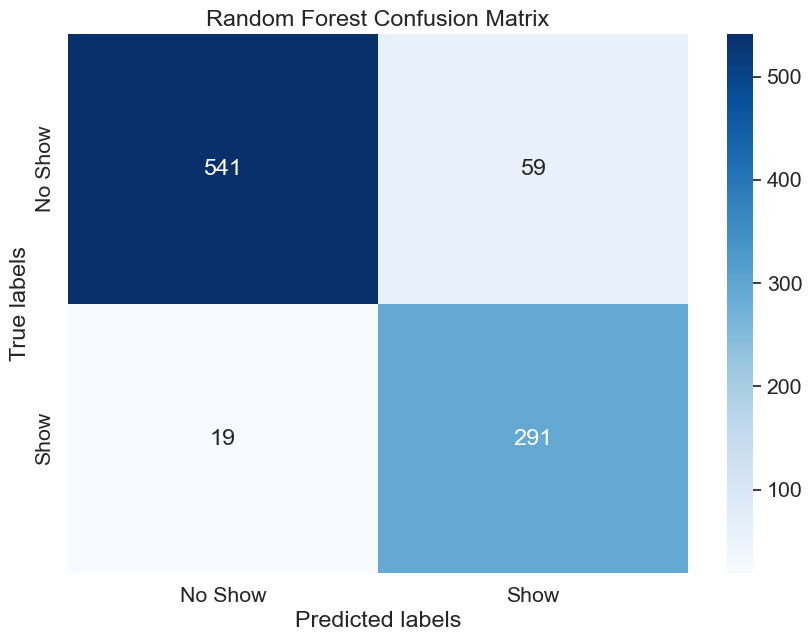

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       600
           1       0.83      0.94      0.88       310

    accuracy                           0.91       910
   macro avg       0.90      0.92      0.91       910
weighted avg       0.92      0.91      0.92       910

Accuracy score: 0.9142857142857143
F1 score: 0.8818181818181818
Recall score: 0.9387096774193548
Precision score: 0.8314285714285714
ROC AUC score: 0.9201881720430107
Threshold: [inf  1.  0.]


In [27]:
# apply a Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

rf_conf_matrix = confusion_matrix(y_test, ypred)


#plot the confusion matrix
class_names = ['No Show', 'Show']
# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 7))  # Adjust the size as necessary
sns.set_theme(context='notebook', font_scale=1.4) # Adjust font scale for better readability

# Create the heatmap
sns.heatmap(rf_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and a title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')


# Show the plot
plt.show()
rf_classification_report = classification_report(y_test, ypred)
print(rf_classification_report)
rf_accuracy_score = accuracy_score(y_test, ypred)
print(f'Accuracy score: {rf_accuracy_score}')
rf_f1_score = f1_score(y_test, ypred)
print(f'F1 score: {rf_f1_score}')
rf_recall_score = recall_score(y_test, ypred)
print(f'Recall score: {rf_recall_score}')
rf_precision_score = precision_score(y_test, ypred)
print(f'Precision score: {rf_precision_score}')
rf_roc_auc_score = roc_auc_score(y_test, ypred)
print(f'ROC AUC score: {rf_roc_auc_score}')
rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

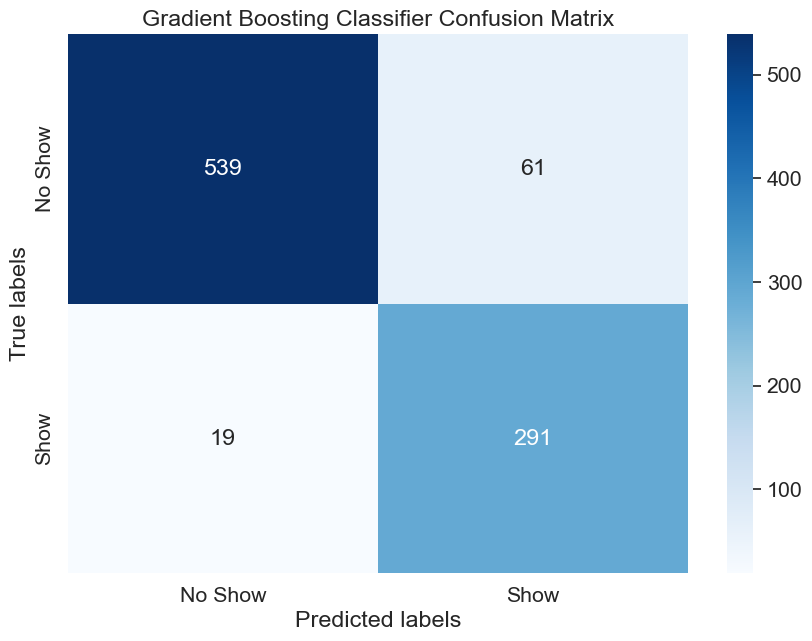

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       600
           1       0.83      0.94      0.88       310

    accuracy                           0.91       910
   macro avg       0.90      0.92      0.91       910
weighted avg       0.92      0.91      0.91       910

Accuracy score: 0.9120879120879121
F1 score: 0.879154078549849
Recall score: 0.9387096774193548
Precision score: 0.8267045454545454
ROC AUC score: 0.918521505376344
Threshold: [inf  1.  0.]


In [28]:
# train and test using gradient boosting classifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc.fit(X_train, y_train)
ypred = gbc.predict(X_test)
gb_conf_matrix = confusion_matrix(y_test, ypred)


#plot the confusion matrix
class_names = ['No Show', 'Show']
# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 7))  # Adjust the size as necessary
sns.set_theme(context='notebook', font_scale=1.4) # Adjust font scale for better readability

# Create the heatmap
sns.heatmap(gb_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and a title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Gradient Boosting Classifier Confusion Matrix')

# Show the plot
plt.show()


gb_classification_report = classification_report(y_test, ypred)
print(gb_classification_report)
gb_accuracy_score = accuracy_score(y_test, ypred)
print(f'Accuracy score: {gb_accuracy_score}')
gb_f1_score = f1_score(y_test, ypred)
print(f'F1 score: {gb_f1_score}')
gb_recall_score = recall_score(y_test, ypred)
print(f'Recall score: {gb_recall_score}')
gb_precision_score = precision_score(y_test, ypred)
print(f'Precision score: {gb_precision_score}')
gb_roc_auc_score = roc_auc_score(y_test, ypred)
print(f'ROC AUC score: {gb_roc_auc_score}')
gbc_fp, gbc_tp, gbc_threshold = roc_curve(y_test, ypred)
print("Threshold:", gbc_threshold)

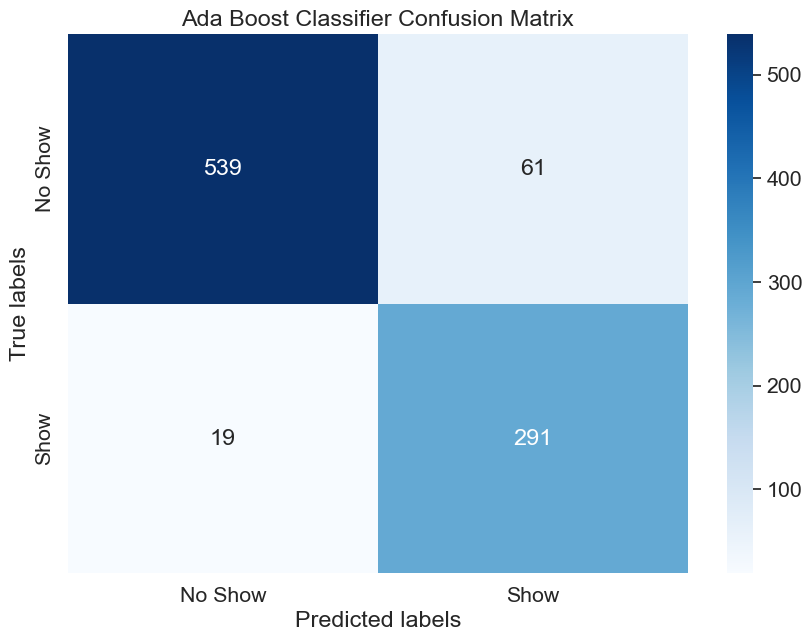

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       600
           1       0.83      0.94      0.88       310

    accuracy                           0.91       910
   macro avg       0.90      0.92      0.91       910
weighted avg       0.92      0.91      0.91       910

Accuracy Score: 0.9131868131868132
F1 Score: 0.8801213960546282
Recall: 0.9354838709677419
Precision: 0.830945558739255
ROC AUC: 0.9185752688172043
Threshold: [inf  1.  0.]


In [29]:
# train and test data using Ada Boost classifier

abc = AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)
abc.fit(X_train, y_train)
ypred = abc.predict(X_test)

abc_confusion_matrix = confusion_matrix(y_test, ypred)

#plot the confusion matrix
class_names = ['No Show', 'Show']
# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 7))  # Adjust the size as necessary
sns.set_theme(context='notebook', font_scale=1.4) # Adjust font scale for better readability
# Create the heatmap
sns.heatmap(gb_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and a title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Ada Boost Classifier Confusion Matrix')

# Show the plot
plt.show()


abc_classification_report = classification_report(y_test, ypred)
print(abc_classification_report)
abc_accuracy_score = accuracy_score(y_test, ypred)
print(f'Accuracy Score: {abc_accuracy_score}')
abc_f1_score = f1_score(y_test, ypred)
print(f'F1 Score: {abc_f1_score}')
abc_recall_score = recall_score(y_test, ypred)
print(f'Recall: {abc_recall_score}')
abc_precision_score = precision_score(y_test, ypred)
print(f'Precision: {abc_precision_score}')
abc_roc_auc_score = roc_auc_score(y_test, ypred)
print(f'ROC AUC: {abc_roc_auc_score}')
abc_fp, abc_tp, abc_threshold = roc_curve(y_test, ypred)
print("Threshold:", abc_threshold)

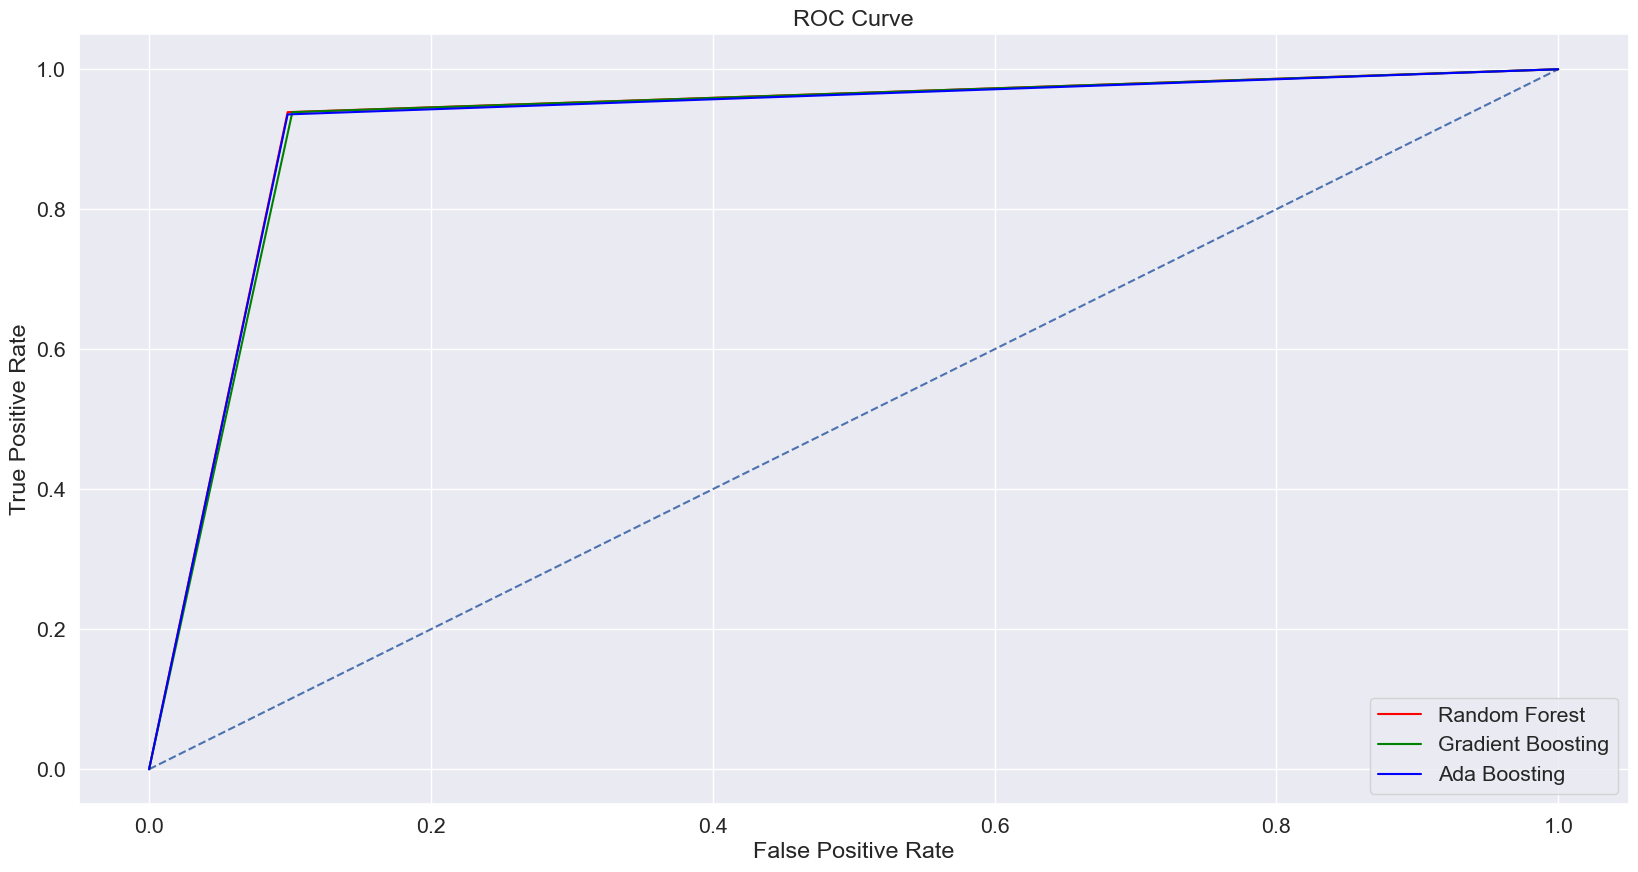

In [30]:
# the ROC curve
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(rf_fp, rf_tp, color="red", label = "Random Forest")
plt.plot(gbc_fp, gbc_tp, color="green", label = "Gradient Boosting")
plt.plot(abc_fp, abc_tp, color="blue", label = "Ada Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

In [31]:
# calculate the predictive power of the features
feature_importance_df = pd.DataFrame(X_train.columns, columns=["Feature"])
feature_importance_df["Importance"] = rf.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
11,TOTAL_NUMBER_OF_NOSHOW,0.549329
10,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,0.066339
7,TOTAL_NUMBER_OF_CANCELLATIONS,0.049956
4,LEAD_TIME,0.045254
1,BOOK_DATE,0.037675
0,APPT_DATE,0.036653
8,TOTAL_NUMBER_OF_RESCHEDULED,0.035479
2,ZIPCODE,0.028930
16,AGE,0.025637
6,APPT_TYPE_STANDARDIZE,0.020641


Text(0.5, 1.0, 'Plot Feature Importances')

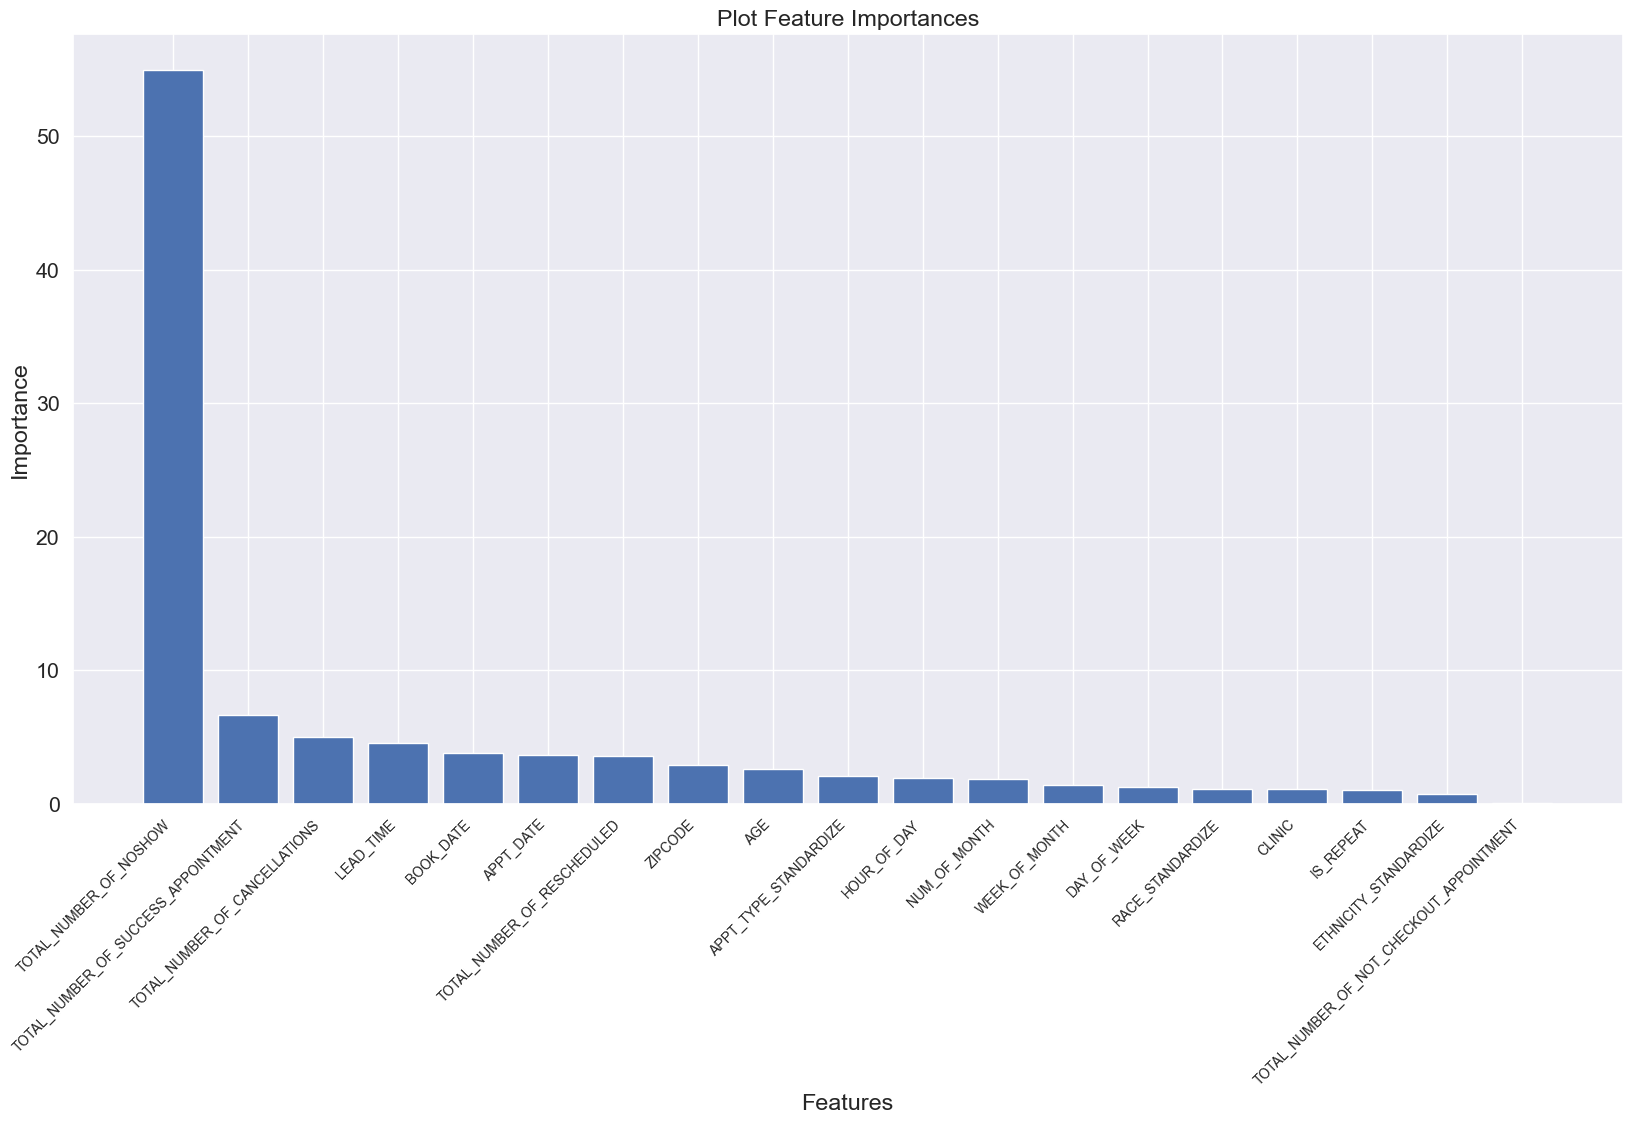

In [32]:
# plot the importance of the features
plt.figure(figsize=(20,10))
ax = feature_importance_df['Feature']
plt.bar(range(feature_importance_df.shape[0]), feature_importance_df['Importance']*100)
#plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xticks(range(feature_importance_df.shape[0]), feature_importance_df['Feature'], rotation = 45, ha="right", fontsize=10)
plt.yticks(np.arange(0, 55, 10))
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

In [33]:
# Choose only these feature to train the model
choosen_feature = ['LEAD_TIME','TOTAL_NUMBER_OF_NOSHOW', 'TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT',
 'TOTAL_NUMBER_OF_CANCELLATIONS', 'TOTAL_NUMBER_OF_RESCHEDULED', 'NUM_OF_MONTH']

In [34]:
new_X = df_sm_resampled[choosen_feature]
new_y = df_sm_resampled['IS_NOSHOW']
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size = 0.3, random_state = 100, stratify= new_y)

In [35]:
nrf = RandomForestClassifier(n_estimators=100, random_state=0)
nrf.fit(X_train, y_train)
ypred = nrf.predict(X_test)

print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))

rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

[[5681  328]
 [ 151 5857]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6009
           1       0.95      0.97      0.96      6008

    accuracy                           0.96     12017
   macro avg       0.96      0.96      0.96     12017
weighted avg       0.96      0.96      0.96     12017

Accuracy Score: 0.9601398019472414
Recall Score: 0.9748668442077231
Precision Score: 0.9469684721099434
ROC AUC Score:  0.9601410273626401
Threshold: [inf  1.  0.]


In [36]:
ypred[:10]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1])

In [37]:
df_sm_resampled[choosen_feature]

,LEAD_TIME,TOTAL_NUMBER_OF_NOSHOW,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_CANCELLATIONS,TOTAL_NUMBER_OF_RESCHEDULED,NUM_OF_MONTH
0,202,0,5,1,2,12
1,363,0,2,0,1,12
2,363,0,2,0,1,12
3,331,0,4,2,8,12
4,342,0,3,1,1,12
...,...,...,...,...,...,...
40049,15,1,1,2,2,7
40050,165,1,0,0,1,10
40051,10,1,0,0,0,1
40052,39,1,0,0,1,6


In [38]:
Y

6420     0
7025     0
6110     0
3862     0
1891     0
        ..
20997    1
21002    1
21007    1
21008    1
21037    1
Name: IS_NOSHOW, Length: 3033, dtype: int64

## Save the model

In [39]:
pickle_out = open("./CHLA_Prediction/random_forest.pkl", "wb")
pickle.dump(nrf, pickle_out)
pickle_out.close()

In [40]:
# test the model
pkl_file = open('./CHLA_Prediction/encoder_V2.pkl', 'rb')
encoder_dict_V2 = pickle.load(pkl_file)
pkl_file.close()

In [41]:
print(encoder_dict_V2)

{'APPT_DATE': ['1/10/19 10:50', '1/10/19 11:25', '1/10/19 13:00', '1/10/19 13:35', '1/10/19 14:10', '1/10/19 14:40', '1/10/19 14:45', '1/10/19 15:20', '1/10/19 8:30', '1/10/19 9:40', '1/10/20 13:00', '1/10/20 13:30', '1/10/20 14:05', '1/10/20 14:40', '1/10/20 15:15', '1/10/20 15:50', '1/10/20 16:25', '1/10/20 8:00', '1/10/20 8:30', '1/10/20 9:00', '1/10/22 10:00', '1/10/22 10:30', '1/10/22 11:00', '1/10/22 11:30', '1/10/22 12:00', '1/10/22 12:30', '1/10/22 13:30', '1/10/22 14:00', '1/10/22 14:30', '1/10/22 15:00', '1/10/22 15:30', '1/10/22 8:00', '1/10/22 9:00', '1/10/22 9:30', '1/10/23 10:00', '1/10/23 10:30', '1/10/23 11:00', '1/10/23 11:30', '1/10/23 12:00', '1/10/23 12:30', '1/10/23 13:30', '1/10/23 14:00', '1/10/23 14:30', '1/10/23 15:00', '1/10/23 15:30', '1/10/23 8:30', '1/10/23 9:00', '1/10/23 9:30', '1/11/22 10:00', '1/11/22 10:30', '1/11/22 11:00', '1/11/22 11:30', '1/11/22 12:00', '1/11/22 12:30', '1/11/22 14:30', '1/11/22 15:00', '1/11/22 15:30', '1/11/22 8:30', '1/11/22 9:

In [42]:
df_model['RACE_STANDARDIZE'].describe()

count     21060
unique        7
top       Other
freq      11111
Name: RACE_STANDARDIZE, dtype: object

In [43]:
# Hard-coded Example data, assuming 'data' dictionary has been defined as in the previous snippet

data = {'APPT_DATE': '1/10/19 10:50', 'BOOK_DATE': '8/29/18 15:18', 'ZIPCODE': '91350', 'CLINIC': 'Never-ARCADIA CARE CENTER', 'LEAD_TIME': 58, 'IS_REPEAT': 'Y', 'APPT_TYPE_STANDARDIZE': 'Follow-up', 'TOTAL_NUMBER_OF_CANCELLATIONS': 1, 'TOTAL_NUMBER_OF_RESCHEDULED': 1, 'TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT': 0, 'TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT': 2, 'TOTAL_NUMBER_OF_NOSHOW': 0,
        'DAY_OF_WEEK': 2, 'WEEK_OF_MONTH': 2, 'NUM_OF_MONTH': 3, 'HOUR_OF_DAY': 11, 'IS_NOSHOW': 'N', 'AGE': 12, 'ETHNICITY_STANDARDIZE': 'Others', 'RACE_STANDARDIZE': 'Other'}

# Convert the data into a DataFrame for easier manipulation
df = pd.DataFrame([data])

df.dtypes

APPT_DATE                                   object
BOOK_DATE                                   object
ZIPCODE                                     object
CLINIC                                      object
LEAD_TIME                                    int64
IS_REPEAT                                   object
APPT_TYPE_STANDARDIZE                       object
TOTAL_NUMBER_OF_CANCELLATIONS                int64
TOTAL_NUMBER_OF_RESCHEDULED                  int64
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT     int64
TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT          int64
TOTAL_NUMBER_OF_NOSHOW                       int64
DAY_OF_WEEK                                  int64
WEEK_OF_MONTH                                int64
NUM_OF_MONTH                                 int64
HOUR_OF_DAY                                  int64
IS_NOSHOW                                   object
AGE                                          int64
ETHNICITY_STANDARDIZE                       object
RACE_STANDARDIZE               

In [44]:
# Load the encoder dictionary from a pickle file
with open('./CHLA_Prediction/encoder_V2.pkl', 'rb') as pkl_file:
    encoder_dict = pickle.load(pkl_file)

# Preprocess and encode the categorical columns
category_col =['APPT_DATE', 'BOOK_DATE', 'ZIPCODE', 'CLINIC', 'IS_REPEAT', 'APPT_TYPE_STANDARDIZE', 'IS_NOSHOW', 'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']

for col in category_col:
    # Initialize a LabelEncoder
    le = preprocessing.LabelEncoder()

     # Convert the loaded classes list to a numpy array with dtype 'object'
    le.classes_ = np.array(encoder_dict[col], dtype=object)

    # Check and replace unknown values with 'Unknown' (ensure 'Unknown' is handled correctly)
    df[col] = df[col].apply(lambda x: x if x in le.classes_ else 'Unknown')

    # If 'Unknown' is not in le.classes_, you need to add it or handle this situation differently
    if 'Unknown' not in le.classes_:
        # This line is just for illustration; handling needs to be decided based on your use case
        print(f"'Unknown' category not handled for {col}. Please adjust.")
        continue

    # Now transform the data
    df[col] = le.transform(df[col])

for col in ['APPT_DATE', 'BOOK_DATE']:
    df[col] = pd.to_datetime(df[col])
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_hour'] = df[col].dt.hour
    df[f'{col}_minute'] = df[col].dt.minute

# Drop the original date columns to prevent the TypeError
df = df.drop(columns=['APPT_DATE', 'BOOK_DATE'])

'Unknown' category not handled for APPT_DATE. Please adjust.
'Unknown' category not handled for BOOK_DATE. Please adjust.
'Unknown' category not handled for ZIPCODE. Please adjust.
'Unknown' category not handled for CLINIC. Please adjust.
'Unknown' category not handled for IS_REPEAT. Please adjust.
'Unknown' category not handled for APPT_TYPE_STANDARDIZE. Please adjust.
'Unknown' category not handled for IS_NOSHOW. Please adjust.
'Unknown' category not handled for ETHNICITY_STANDARDIZE. Please adjust.
'Unknown' category not handled for RACE_STANDARDIZE. Please adjust.


In [45]:
# Load the encoder dictionary from a pickle file
with open('./CHLA_Prediction/encoder_V2.pkl', 'rb') as pkl_file:
    encoder_dict = pickle.load(pkl_file)
    
# Preprocess and encode the categorical columns

In [46]:
# Prediction Section

model = pickle.load(open('./CHLA_Prediction/random_forest.pkl', 'rb'))
features_list = df_sm_resampled[choosen_feature].values.tolist()
prediction = model.predict(features_list)
#prediction = gbc.predict(features_list)
print(prediction[0])

0


/Users/axu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [47]:
df_sm_resampled[choosen_feature].dtypes

LEAD_TIME                              int64
TOTAL_NUMBER_OF_NOSHOW                 int64
TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT    int64
TOTAL_NUMBER_OF_CANCELLATIONS          int64
TOTAL_NUMBER_OF_RESCHEDULED            int64
NUM_OF_MONTH                           int64
dtype: object

## Local deployment and testing of the model

In [48]:
!pip install streamlit

In [50]:
!streamlit run ./CHLA_Prediction/streamlit_app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.27.253.110:8501

/Users/axu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
^C
  Stopping...
